In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import IPython.display as ipd
from IPython.core.display import display
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input

In [2]:
#Import training data -- mel spectrogram
train_mel_spec_normalised = np.load('../input/esc-50-cip-project-sound/train_mel_spec_normalised.npy',allow_pickle=True)

In [3]:
train_mel_spec_normalised[:5]

array([[array([[[0.6041918 ],
        [0.71123034],
        [1.        ],
        ...,
        [1.0000001 ],
        [0.57045317],
        [0.4912951 ]],

       [[0.31148118],
        [0.3597656 ],
        [0.27675688],
        ...,
        [0.58652306],
        [0.6944339 ],
        [0.25559342]],

       [[0.49951017],
        [0.427239  ],
        [0.46614778],
        ...,
        [0.5739975 ],
        [0.6643448 ],
        [0.20714664]],

       ...,

       [[0.31594032],
        [0.28517455],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.07990193],
        [0.04656494],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32),
        32],
       [array([[[0.23401666],
        [0.2761431 ],
        [0.13441

In [4]:
#Extract specrogram image from train data -- seperates out category
x_train_mel = np.zeros((1,128,216))
for i in tqdm(range(3799)):
    x_train_mel = np.append(x_train_mel,[train_mel_spec_normalised[i][0][:,:,-1]],axis=0)


100%|██████████| 3799/3799 [09:57<00:00,  6.36it/s]


In [5]:
#Remove first element
x_train_mel = x_train_mel[1:,:,:]

In [6]:
#Add a single channel for a mono channel image
x_train_mel = x_train_mel[:,:,:,np.newaxis]

In [7]:
#Extracting out the categories
y_train_mel = []
for i in range(3799):
    y_train_mel.append(train_mel_spec_normalised[i][1])

In [8]:
y_train_mel = np.array(y_train_mel)

# **Model 1 - Mel Spectrogram**

In [9]:
model_input = Input(shape=(128,216,1))

In [10]:
def create_keras_model_1(model_input, num_classes):
    x = Conv2D(64, kernel_size=3, activation="relu")(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(model_input, x, name='model_1')
    
    return model

In [11]:
y_train_mel = y_train_mel.reshape(3799,1)
y_train_mel.shape

(3799, 1)

In [12]:
callbacks1 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             ),
]


In [13]:
model_mel_1 = create_keras_model_1(model_input,50)
model_mel_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 216, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 214, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 107, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 105, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 52, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 50, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 25, 256)       0   

In [14]:
model_mel_1.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [15]:
# Training and Evaluation of the model
h1 = model_mel_1.fit(x_train_mel, y_train_mel,verbose=1, batch_size = 30 ,epochs=200,validation_split=0.1, callbacks = callbacks1)

Epoch 1/200
114/114 [==============================] - 9s 40ms/step - loss: 3.8642 - accuracy: 0.0409 - val_loss: 3.4206 - val_accuracy: 0.1553
Epoch 2/200
114/114 [==============================] - 4s 31ms/step - loss: 3.3108 - accuracy: 0.1484 - val_loss: 2.8560 - val_accuracy: 0.3263
Epoch 3/200
114/114 [==============================] - 4s 32ms/step - loss: 2.7978 - accuracy: 0.2608 - val_loss: 2.4356 - val_accuracy: 0.3895
Epoch 4/200
114/114 [==============================] - 4s 32ms/step - loss: 2.3179 - accuracy: 0.3520 - val_loss: 2.0155 - val_accuracy: 0.4526
Epoch 5/200
114/114 [==============================] - 4s 32ms/step - loss: 2.0767 - accuracy: 0.4252 - val_loss: 1.7176 - val_accuracy: 0.5868
Epoch 6/200
114/114 [==============================] - 4s 31ms/step - loss: 1.7160 - accuracy: 0.5079 - val_loss: 1.5459 - val_accuracy: 0.6053
Epoch 7/200
114/114 [==============================] - 4s 32ms/step - loss: 1.5215 - accuracy: 0.5563 - val_loss: 1.2207 - val_accuracy:

In [16]:
h1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [17]:
def plot_metrics(h):
    #Plotting metrics
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss']);
    plt.plot(h.history['val_loss']);
    plt.title("Loss vs Epochs");
    plt.ylabel("Loss");
    plt.xlabel("Epochs");
    plt.legend(['train', 'val']);

    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Accuracy vs Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


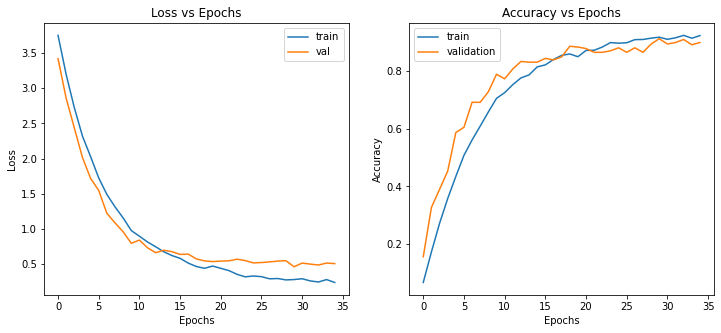

In [18]:
plot_metrics(h1)

In [19]:
model_mel_1.save('mel_model_1.h5')

# **Model 2 - Mel Spectrogram**

In [20]:
def create_keras_model_2(model_input, num_classes):

    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(model_input)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(model_input, x, name='model_2')

    return model

In [21]:
model_mel_2 = create_keras_model_2(model_input,50)

In [22]:
callbacks_2 = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             ),
]


In [23]:
from sklearn.model_selection import train_test_split
x_training_mel,x_val,y_training_mel,y_val = train_test_split(x_train_mel,y_train_mel,stratify = y_train_mel)

In [24]:
model_mel_2.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


In [25]:
h2 = model_mel_2.fit(x_training_mel, y_training_mel, batch_size=64, epochs=200, verbose=1, validation_data=(x_val,y_val),callbacks = callbacks_2)

Epoch 1/200
45/45 [==============================] - 5s 80ms/step - loss: 4.2437 - accuracy: 0.0494 - val_loss: 5.6996 - val_accuracy: 0.0200
Epoch 2/200
45/45 [==============================] - 3s 64ms/step - loss: 3.3340 - accuracy: 0.1454 - val_loss: 5.1848 - val_accuracy: 0.0211
Epoch 3/200
45/45 [==============================] - 3s 62ms/step - loss: 2.8193 - accuracy: 0.2743 - val_loss: 4.7158 - val_accuracy: 0.0221
Epoch 4/200
45/45 [==============================] - 3s 62ms/step - loss: 2.3905 - accuracy: 0.3923 - val_loss: 4.4256 - val_accuracy: 0.0326
Epoch 5/200
45/45 [==============================] - 3s 65ms/step - loss: 2.0688 - accuracy: 0.4812 - val_loss: 4.6901 - val_accuracy: 0.0316
Epoch 6/200
45/45 [==============================] - 3s 63ms/step - loss: 1.7728 - accuracy: 0.5488 - val_loss: 4.5620 - val_accuracy: 0.0316
Epoch 7/200
45/45 [==============================] - 3s 62ms/step - loss: 1.5131 - accuracy: 0.6231 - val_loss: 4.0590 - val_accuracy: 0.0684
Epoch 

In [26]:
h2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

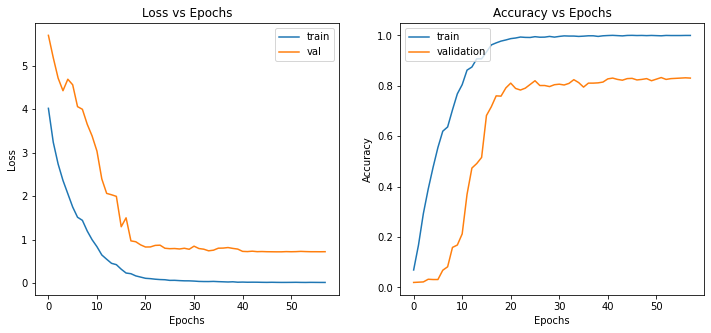

In [27]:
plot_metrics(h2)

In [28]:
model_mel_2.save('mel_model_2.h5')

## **Testing accuracy**

In [29]:
mel_test_data_cat = np.load('../input/test-data-esc-50/mel_test_data_cat.npy',allow_pickle=True)

In [30]:
x_test_mel = np.zeros((1,128,216))
for i in tqdm(range(200)):
    x_test_mel = np.append(x_test_mel,[mel_test_data_cat[i][0][:,:,-1]],axis=0)

100%|██████████| 200/200 [00:01<00:00, 172.45it/s]


In [31]:
x_test_mel = x_test_mel[1:,:,:]

In [32]:
x_test_mel = x_test_mel[:,:,:,np.newaxis]

In [33]:
y_test_mel = []
for i in range(200):
    y_test_mel.append(mel_test_data_cat[i][1])

In [34]:
y_test_mel = np.array(y_test_mel)

In [35]:
len(y_test_mel)

200

In [36]:
#Model 1 test results
results = model_mel_1.evaluate(x_test_mel, y_test_mel, batch_size=32)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 20ms/step - loss: 0.8282 - accuracy: 0.8650
test loss, test acc: [0.8281658887863159, 0.8650000095367432]


In [37]:
#Model 2 test results
results = model_mel_2.evaluate(x_test_mel, y_test_mel, batch_size=32)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 16ms/step - loss: 0.7571 - accuracy: 0.8300
test loss, test acc: [0.7571437954902649, 0.8299999833106995]
